In [4]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("ITC_Stock").getOrCreate()

# Read ITC data from HDFS
df = spark.read.csv("hdfs://localhost:9000/bigdata/itc/ITC_minute.csv", header=True, inferSchema=True)

df.show(5)
df.printSchema()


+----------------+------+------+------+------+------+
|            date|  open|  high|   low| close|volume|
+----------------+------+------+------+------+------+
|02-02-2015 09:15| 211.6|212.75|211.55|212.25|152000|
|02-02-2015 09:16| 212.2| 212.3|211.45|211.75| 76319|
|02-02-2015 09:17|211.85|212.25| 211.8|212.15| 42411|
|02-02-2015 09:18| 212.1|212.15|212.05|212.15| 44466|
|02-02-2015 09:19|212.15| 212.5|212.15| 212.5| 90079|
+----------------+------+------+------+------+------+
only showing top 5 rows
root
 |-- date: string (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- close: double (nullable = true)
 |-- volume: integer (nullable = true)



# Feature Engineering

In [3]:
from pyspark.sql.functions import col, to_timestamp

# convert date to proper timestamp
df = df.withColumn("date", to_timestamp(col("date"), "dd-MM-yyyy HH:mm")) \
       .orderBy("date")

print("Done")

Done


In [4]:
pdf = df.select("date", "close").toPandas()
pdf.set_index("date", inplace=True)

print("Done")

Done


In [5]:
# Normalising Data

from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(pdf[['close']])

print("done")

done


In [6]:
# 60 timestamps -> next close (ie) 1 min interval 

def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

# Reshape for LSTM: (samples, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

print("Done")


Done


In [7]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("Done, Ready for Training and Test")

Done, Ready for Training and Test


# Model Building

In [8]:
# LSTM

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


2025-08-27 13:04:08.048883: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-27 13:04:08.054475: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-27 13:04:08.476384: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-27 13:04:09.838139: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

# Model Training

In [9]:
# Training

history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test),
                    epochs=20, batch_size=64)


Epoch 1/20
12157/12157 ━━━━━━━━━━━━━━━━━━━━ 269s 22ms/step - loss: 2.2903e-04 - val_loss: 1.0483e-04
Epoch 2/20
12157/12157 ━━━━━━━━━━━━━━━━━━━━ 275s 23ms/step - loss: 8.3148e-05 - val_loss: 2.9271e-06
Epoch 3/20
12157/12157 ━━━━━━━━━━━━━━━━━━━━ 275s 23ms/step - loss: 7.7963e-05 - val_loss: 5.7041e-06
Epoch 4/20
12157/12157 ━━━━━━━━━━━━━━━━━━━━ 1528s 126ms/step - loss: 7.5409e-05 - val_loss: 2.5202e-05
Epoch 5/20
12157/12157 ━━━━━━━━━━━━━━━━━━━━ 269s 22ms/step - loss: 7.4734e-05 - val_loss: 2.9813e-04
Epoch 6/20
12157/12157 ━━━━━━━━━━━━━━━━━━━━ 275s 23ms/step - loss: 7.2045e-05 - val_loss: 5.6304e-04
Epoch 7/20
12157/12157 ━━━━━━━━━━━━━━━━━━━━ 297s 24ms/step - loss: 7.1442e-05 - val_loss: 6.4615e-05
Epoch 8/20
12157/12157 ━━━━━━━━━━━━━━━━━━━━ 281s 23ms/step - loss: 7.0597e-05 - val_loss: 2.2298e-04
Epoch 9/20
12157/12157 ━━━━━━━━━━━━━━━━━━━━ 283s 23ms/step - loss: 6.9697e-05 - val_loss: 5.0882e-05
Epoch 10/20
12157/12157 ━━━━━━━━━━━━━━━━━━━━ 286s 24ms/step - loss: 6.9339e-05 - val_loss

In [10]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions.reshape(-1,1))

y_test_real = scaler.inverse_transform(y_test.reshape(-1,1))


6079/6079 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step


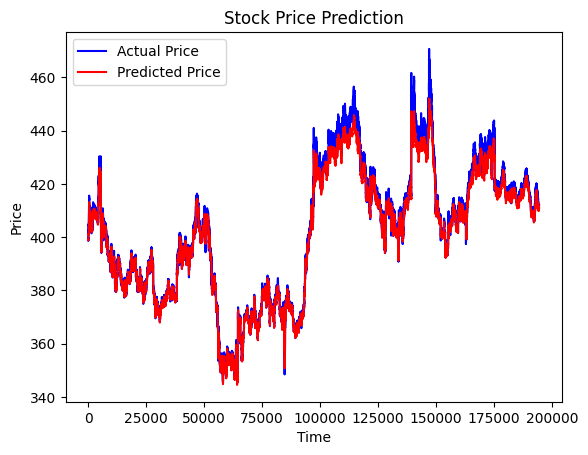

In [11]:
import matplotlib.pyplot as plt

plt.plot(y_test_real, color='blue', label='Actual Price')
plt.plot(predictions, color='red', label='Predicted Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [17]:
# Model Save

# Save the full model (architecture + weights + optimizer state)
model.save('itc_lstm_model.keras')

import pickle

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("done")


done


In [1]:
from alpha_vantage.timeseries import TimeSeries
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
import pickle

# ---------------------------
# Load Alpha Vantage Data
# ---------------------------
api_key = "R9SUJLHNB1HWPE3W"
symbol = "ITC.BSE"

ts = TimeSeries(key=api_key, output_format='pandas')
data, meta_data = ts.get_daily(symbol=symbol, outputsize="full")  # full historical data
data = data[['4. close']]
data.rename(columns={'4. close': 'Close'}, inplace=True)

# Convert index to datetime and reverse to chronological order
data = data[::-1].reset_index()
data['date'] = pd.to_datetime(data['date'])

# Filter for August 2025
august_data = data[(data['date'].dt.year == 2025) & (data['date'].dt.month == 9)].reset_index(drop=True)
print("September 2025 Data:\n", august_data)

# ---------------------------
# Load Model and Scaler
# ---------------------------
model = load_model("itc_lstm_model.keras")
with open("scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

# ---------------------------
# Prepare Last 60 Close Prices
# ---------------------------
# Use the last 60 days of August 2025 or fewer if less data
last_60_prices = august_data['Close'].values[-60:]
last_60_prices_df = pd.DataFrame(last_60_prices, columns=['close'])

# Scale and reshape
scaled_prices = scaler.transform(last_60_prices_df)
X_live = scaled_prices.reshape(1, len(last_60_prices), 1)  # LSTM input shape

# ---------------------------
# Predict Trend
# ---------------------------
predicted_value = model.predict(X_live)
trend = "Bullish" if predicted_value > 0.5 else "Bearish"
print("Tomorrow's Predicted Trend:", trend)
print("Raw Model Output:", predicted_value[0][0])



2025-09-16 19:53:11.563444: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-16 19:53:12.006880: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-16 19:53:13.589724: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


September 2025 Data:
          date   Close
0  2025-09-01  405.70
1  2025-09-02  406.65
2  2025-09-03  411.50
3  2025-09-04  415.85
4  2025-09-05  407.50
5  2025-09-08  407.40
6  2025-09-09  410.20
7  2025-09-10  412.95
8  2025-09-11  415.00
9  2025-09-12  413.60
10 2025-09-15  412.65


I0000 00:00:1758032598.375080    9383 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2607 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
Tomorrow's Predicted Trend: Bullish
Raw Model Output: 0.7290702


2025-09-16 19:53:19.313927: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91200
